In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
#from  utilities import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import glob
import h5py
import cv2

In [2]:
class ReseauNeuronesArtificiel():
    def _init__(self, W, b):
        self.W = W
        self.b = b
        self.learning_rate = None
        self.X_train = None
        self.y_train = None
        self.cout = None
    
    def __model(self, X):
        Z=X.dot(self.W) + self.b
        A=1/(1+np.exp(-Z))
        return A
    
    def __initialisation(self, X, y, learning_rate):
        self.X_train = X
        self.y_train = y
        self.W=np.random.randn(self.X_train.shape[1],1)
        self.b=np.random.randn(1)
        self.learning_rate = learning_rate
        self.cout = []
    
    def __logLoss(self, A):
        return 1/len(self.y_train)*np.sum(-self.y_train*np.log(A)-(1-self.y_train)*np.log(1-A))
    
    def __gradient(self, A):
        dW=1/len(self.y_train)*np.dot(self.X_train.T,A-self.y_train)
        db=1/len(self.y_train)*sum(A-self.y_train)
        return (dW,db)
    
    def __update(self,dW,db):
        self.W=self.W-self.learning_rate*dW
        self.b=self.b-self.learning_rate*db

    def fit(self, X,y, learning_rate=0.1, n_iter=10000):
        #initialisation
        self.__initialisation(X, y, learning_rate)
        
        for i in tqdm(range(n_iter)):
            A=self.__model(X,)
            self.cout.append(self.__logLoss(A))
            dW,db=self.__gradient(A)
            self.__update(dW,db)
        
        y_pred=self.predict(X)
        
        return y_pred
        
    def predict(self, X_predict):
        A=self.__model(X_predict)
        #print(A)
        return A>=0.5

In [3]:
def images_to_hdf5_dataset(imageFormat, data_repo, h5file, img_width, img_height):
    nfiles = len(glob.glob(data_repo+"*.jpg"))
    print(f'count of image files nfiles={nfiles}')

    #on load les images de chats du training set pour les transformer en matrices
    with h5py.File(h5file,'w') as  h5f:
        x = h5f.create_dataset('X',shape=(nfiles, img_width, img_height), dtype=int)
        y = h5f.create_dataset('y',shape=(nfiles,), dtype=int)

        for cnt, ifile in tqdm(enumerate(glob.iglob(data_repo+"*."+imageFormat))):
            img = cv2.imread(ifile, cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize( img, (img_width, img_height) )

            x[cnt] = img_resize
            #le label est 1 si la photo contient un chat
            if 'cat' in ifile:
                y[cnt] = 1
            else:
                #le label est 0 si la photo contient un chien
                y[cnt] = 0


In [4]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

repo_training_set = "data/train_set/"
repo_test_set = "data/test_set/"
dataset_train = "dataset/train_set.hdf5"
dataset_test = "dataset/test_set.hdf5"

#on convertit les images du train set en un fichier hdf5
images_to_hdf5_dataset("jpg", repo_training_set, dataset_train, IMG_WIDTH, IMG_HEIGHT)

#on fait la meme chose pour les images du test set
images_to_hdf5_dataset("jpg", repo_test_set, dataset_test, IMG_WIDTH, IMG_HEIGHT)

count of image files nfiles=697


697it [00:02, 346.02it/s]


count of image files nfiles=2023


2023it [00:01, 1457.28it/s]


In [5]:
#on load le dataset d'entrainement
dataset = h5py.File(dataset_train, "r")

X_train = np.array(dataset["X"][:]) 
y_train = np.array(dataset["y"][:])

#on load le dataset de test
dataset = h5py.File(dataset_test, "r")

X_test = np.array(dataset["X"][:]) 
y_test = np.array(dataset["y"][:])

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(697, 64, 64) (697,)
(2023, 64, 64) (2023,)


In [6]:
print(X_train[y_train == 0].shape)
print(X_test[y_test == 0].shape)

(348, 64, 64)
(1012, 64, 64)


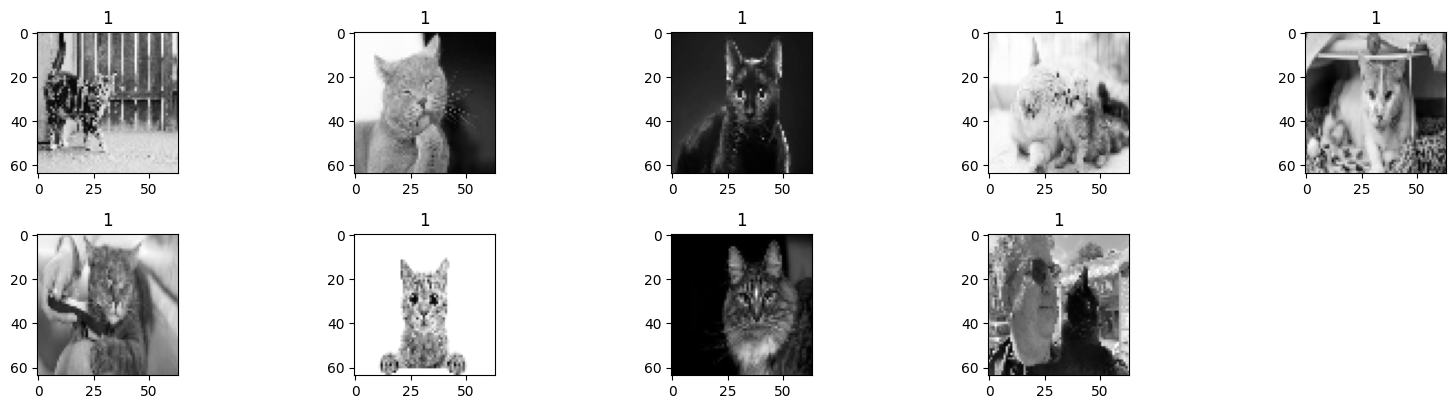

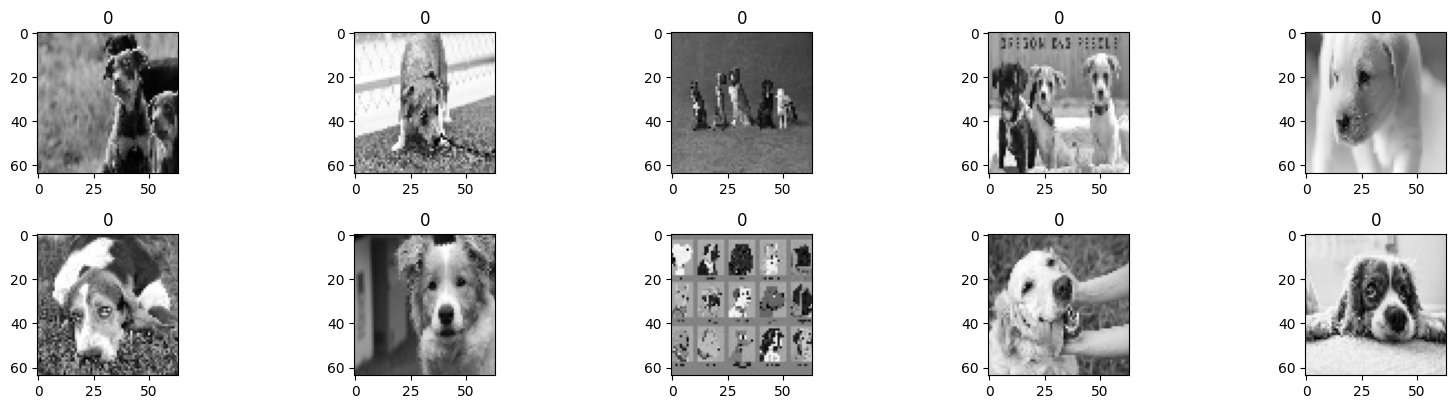

In [7]:
plt.figure(figsize=(16,8))
j = 1
for i in range(1,10):
    plt.subplot(4,5,j)
    plt.imshow(X_train[i],cmap='gray')
    plt.title (y_train[i])
    plt.tight_layout()
    j += 1
plt.show()

j = 1
plt.figure(figsize=(16,8))
for i in range(390,400):
    plt.subplot(4,5,j)
    plt.imshow(X_train[i],cmap='gray')
    plt.title (y_train[i])
    plt.tight_layout()
    j += 1
plt.show()

In [8]:
#on change la taille de la matrice
X_train = X_train.reshape(X_train.shape[0],-1)/X_train.max()
print(X_train.shape)

#on reshape la matrice y
y_train = y_train.reshape(y_train.shape[0], 1)

(697, 4096)


C:\Users\AntoninDurand\AppData\Local\Temp\ipykernel_8756\3042325136.py:24: RuntimeWarning: divide by zero encountered in log
  return 1/len(self.y_train)*np.sum(-self.y_train*np.log(A)-(1-self.y_train)*np.log(1-A))
C:\Users\AntoninDurand\AppData\Local\Temp\ipykernel_8756\3042325136.py:24: RuntimeWarning: invalid value encountered in multiply
  return 1/len(self.y_train)*np.sum(-self.y_train*np.log(A)-(1-self.y_train)*np.log(1-A))


0.6355810616929699


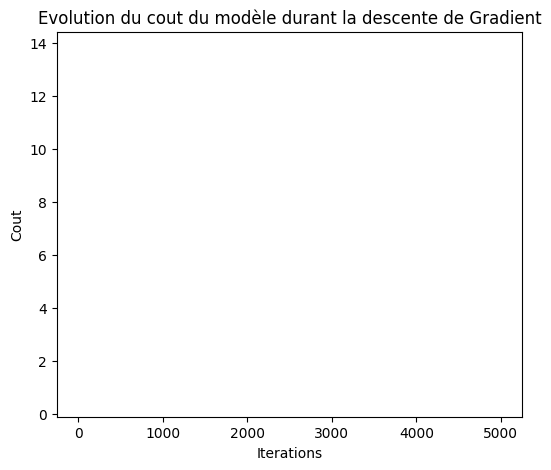

In [9]:
rn = ReseauNeuronesArtificiel()
y_train_pred = rn.fit(X_train, y_train, learning_rate=0.05, n_iter=5000)

#on affiche les performances de notre modèle
print(accuracy_score(y_train, y_train_pred))

#on représente graphiquement l'évolution du cout du modele
plt.figure(figsize=(6,5))

plt.plot(rn.cout)

plt.title("Evolution du cout du modèle durant la descente de Gradient")
plt.xlabel("Iterations")
plt.ylabel("Cout")

plt.show()

In [11]:
#on change la taille de la matrice
X_test = X_test.reshape(X_test.shape[0],-1)/X_test.max()
print(X_test.shape)

#on reshape la matrice y
y_train = y_train.reshape(y_train.shape[0], 1)

#on teste maintenant le modèle avec le test set
y_test_pred = rn.predict(X_test)

#on affiche les performances de notre modèle
print(accuracy_score(y_test, y_test_pred))

(2023, 4096)
0.5056846267918932


100%|██████████| 10000/10000 [00:54<00:00, 183.24it/s]


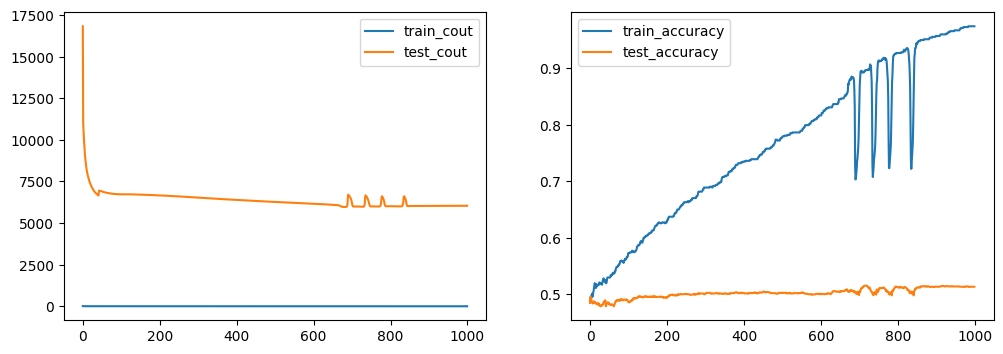

In [15]:
def initialisation (X):
    W=np.random.randn(X.shape[1],1)
    b=np.random.randn(1)
    return (W, b)

def model(X,W,b):
    Z=X.dot(W)+b
    A=1/(1+np.exp(-Z))
    return A

def logLoss(A,y):
    epsilon=1e-15
    return 1/len(y)*np.sum(-y*np.log(A+epsilon)-(1-y)*np.log(1-A+epsilon))

def gradients (A,X,y):
    dW=1/len(y)*np.dot(X.T,A-y)
    db=1/len(y)*sum(A-y)
    return (dW,db)

def update(dW,db, W, b, learning_rate):
    W=W-learning_rate*dW
    b=b-learning_rate*db
    return (W,b)

def prediction(X,W,b):
    A=model(X,W,b)
    #print(A)
    return A>=0.5

def artificialNeuron(x_train,y_train,x_test,y_test, learning_rate=0.05, n_iter=10000): 
    #initialisation
    W,b=initialisation(x_train) 
    train_cout=[]
    train_accuracy=[]
    test_cout=[]
    test_accuracy=[]
        
    cout=[] 
    accuracy=[]
    for i in tqdm(range(n_iter)): 
        # activation     
        A=model(x_train,W,b)
        if i%10==0:
            #train cout/accuracy
            train_cout.append(logLoss(A,y_train)) 
            #precision
            y_pred=prediction(x_train,W,b)
            train_accuracy.append(accuracy_score(y_train,y_pred))
            #test cout/accuracy
            A_test=model(x_test, W,b)
            test_cout.append(logLoss(A_test,y_test)) 
            #precision
            y_pred=prediction(x_test,W,b)
            test_accuracy.append(accuracy_score(y_test,y_pred))
                    
        #mise à jour
        dW,db=gradients(A,x_train,y_train)
        W,b= update(dW,db,W,b,learning_rate)
            
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_cout, label='train_cout')
    plt.plot(test_cout, label='test_cout')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.legend()
    plt.show()
    return (W,b)

W,b=artificialNeuron(X_train,y_train,X_test, y_test)